In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



In [25]:

df = pd.read_parquet("../../datasets/amazon_user_reviews_text_sentiment.parquet")

# Ensure correct columns
texts = df["text_cleaned"].astype(str).values
labels = df["sentiment"].values

X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

max_vocab_size = 20000
max_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")


model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length, mask_zero=True),
    SimpleRNN(128),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 128)          2560000   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 3)                 195       
                                                                 
Total params: 2,601,347
Trainable params: 2,601,347
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
207/207 [==============================] - 11s 51ms/step - loss: 0.9656 - accuracy: 0.5063 - val_loss: 0.8608 - val_accuracy: 0.5897
Epoch 2/20
207/207 [============

115/115 [==============================] - 1s 8ms/step
MODEL EVALUATION METRICS
Accuracy:  0.6046
Precision: 0.5934
Recall:    0.6046
F1-Score:  0.5852

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.67      0.76      0.71      1243
           1       0.53      0.31      0.39      1209
           2       0.58      0.74      0.65      1228

    accuracy                           0.60      3680
   macro avg       0.59      0.60      0.58      3680
weighted avg       0.59      0.60      0.59      3680

ROC=AUC REPORT
AUC score: 0.781124155958143


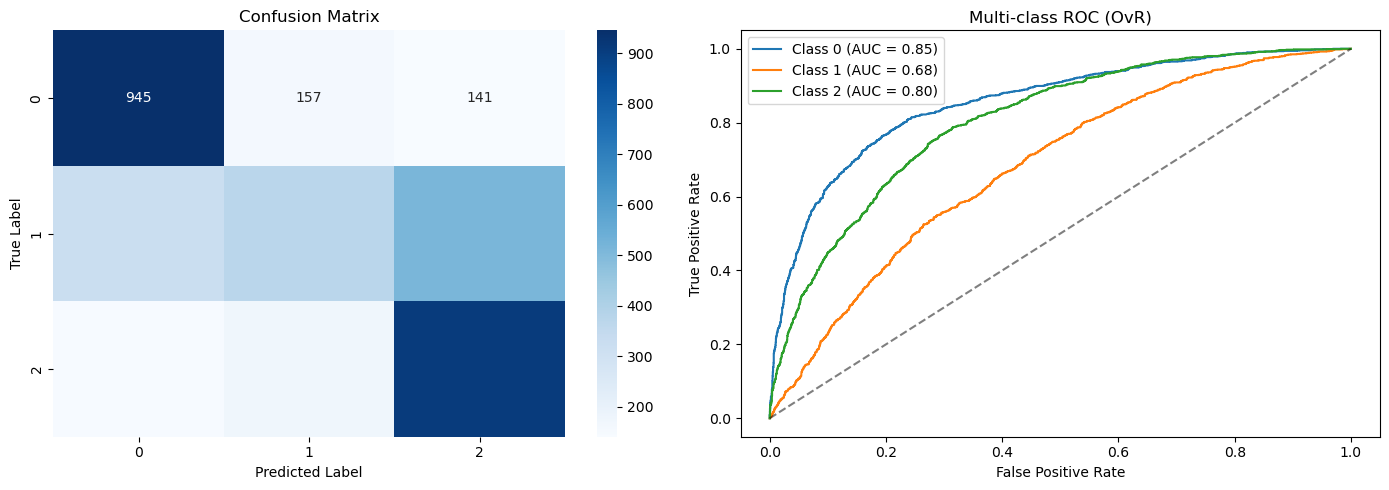

In [26]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

# ModelEvaluation
from ModelEvaluation.ModelEvaluation import ModelEvaluation
# Model Evaluation

preds = model.predict(X_test_pad)
y_pred = np.argmax(preds, axis=1)
evaluator = ModelEvaluation()
evaluator.run_pipeline(y_test, y_pred, preds)